In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

from joblib import dump

import os
import joblib
import pickle
import sys
from scipy import stats


sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions


In [4]:
print(sys.executable)

/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/bin/python


In [47]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    return df

df_train = load_data('train')
df_val = load_data('val')

Concatente all df to one
Concatente all df to one


In [79]:
### INSPECT WEIRD FORBIDDEM VALUES (no water content but bcp)
tsubsi_forbidden = df_train.tsubsi[(df_train.tsubsi < -0.0001) & (df_train.SIWC == 0)]
tmeltsi_forbidden = df_train.tmeltsi[(df_train.tmeltsi < -0.0001) & (df_train.SIWC == 0)]
tevr_forbidden = df_train.tevr[(df_train.tevr < -0.0001) & (df_train.RWC == 0)]

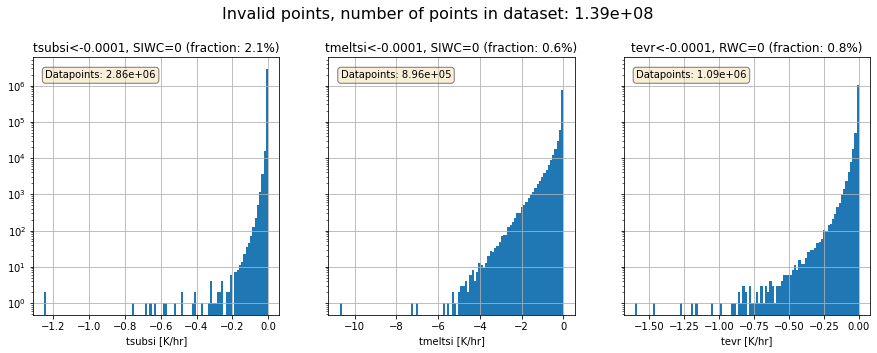

In [80]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)

ax[0].hist(tsubsi_forbidden, log=True, bins=100)
ax[0].grid(True)

ax[1].hist(tmeltsi_forbidden, log=True, bins=100)
ax[1].grid(True)

ax[2].hist(tevr_forbidden, log=True, bins=100)
ax[2].grid(True)

ax[0].set_title(f'tsubsi<-0.0001, SIWC=0 (fraction: {(tsubsi_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[0].set_xlabel('tsubsi [K/hr]')
# Add datapoint count in a text box for the first plot
ax[0].text(0.05, 0.95, f'Datapoints: {tsubsi_forbidden.shape[0]:2.2e}', transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[1].set_title(f'tmeltsi<-0.0001, SIWC=0 (fraction: {(tmeltsi_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[1].set_xlabel('tmeltsi [K/hr]')
# Add datapoint count in a text box for the second plot
ax[1].text(0.05, 0.95, f'Datapoints: {tmeltsi_forbidden.shape[0]:2.2e}', transform=ax[1].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[2].set_title(f'tevr<-0.0001, RWC=0 (fraction: {(tevr_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[2].set_xlabel('tevr [K/hr]')
# Add datapoint count in a text box for the third plot
ax[2].text(0.05, 0.95, f'Datapoints: {tevr_forbidden.shape[0]:2.2e}', transform=ax[2].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle(f'Invalid points, number of points in dataset: {df_train.shape[0]:.2e}', fontsize=16)
plt.subplots_adjust(top=0.84)
plt.show()


In [6]:
## Drop unnecessary columns
df_train = df_train.drop(['tevr', 'RWC', 'tsubsi'], axis=1)
df_val = df_val.drop(['tevr', 'RWC', 'tsubsi'], axis=1)


In [7]:
print(df_train.shape)
print(df_val.shape)

(138658804, 6)
(14548323, 6)


In [8]:
df_tmeltsi_train = rf_functions.apply_domainfilter(df=df_train,
                                                   water_type='SIWC',
                                                   scale_temp=False,
                                                   verbose=1,
                                                   temp_filter=True,
                                                   output_filter=False)

Drop all points where SIWC == 0 and Temp < 0
Filtered dataframe size:	3.99e+06 	2.9% of size compared to unfiltered. (Points dropped: 134665403)

	bcp_label was not part of dataframe, will create the labels now for following stats...

Class 0 fraction (before drop):	98.9%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	66.9%		2670307 Points
Class 1 fraction:	26.4%		1053977 Points
Class 2 fraction:	 6.7%		 269117 Points
------------------------------		--------------
Toatal points in new df:		3993401 Points




In [9]:
df_tmeltsi_val = rf_functions.apply_domainfilter(df=df_val,
                                                 water_type='SIWC',
                                                 verbose=1,
                                                 temp_filter=True,
                                                 scale_temp=False,output_filter=False)

Drop all points where SIWC == 0 and Temp < 0
Filtered dataframe size:	3.91e+05 	2.7% of size compared to unfiltered. (Points dropped: 14157334)

	bcp_label was not part of dataframe, will create the labels now for following stats...

Class 0 fraction (before drop):	99.0%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	67.2%		 262698 Points
Class 1 fraction:	25.8%		 100937 Points
Class 2 fraction:	 7.0%		  27354 Points
------------------------------		--------------
Toatal points in new df:		 390989 Points




In [10]:
# Define the predictors and the target
target = 'tmeltsi'

X_train = df_tmeltsi_train.drop([target], axis=1)
y_train = df_tmeltsi_train[target]

X_val = df_tmeltsi_val.drop([target], axis=1)
y_val = df_tmeltsi_val[target]

In [11]:
X_train

,CC,T,OMEGA,SIWC,RH_ifs
261,0.015625,2.381683,0.061454,0.003858,0.878177
299,0.078125,1.998627,0.080702,0.042146,0.898980
311,0.000000,1.807343,0.076540,0.015261,0.919767
330,0.000000,2.127655,0.030886,0.008523,0.828871
337,0.078125,1.662811,0.101443,0.078710,0.915377
...,...,...,...,...,...
138648670,0.023438,0.079803,-1.303955,0.009321,0.664307
138648671,0.023438,0.742889,-0.005371,0.000104,0.515708
138648672,0.015625,0.746796,-0.655762,0.010349,0.662270
138648680,0.000000,0.074921,-0.012451,0.000097,0.474936


In [12]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

In [13]:
import itertools


def grid_search_with_validation_set_f1(X_train, y_train, X_val, y_val, param_grid, save_name, threshold=-0.1):

    best_mse = np.inf
    best_f1 = -np.inf
    best_params_mse = None
    best_params_f1 = None
    best_model_mse = None
    best_model_f1 = None

    total_iter = 1
    for key in param_grid.keys():
        total_iter *= len(param_grid[key])
    current_i = 0
    print('\nStart Grid-Search:')
    # Loop over the parameter grid
    for params in itertools.product(*param_grid.values()):
        current_i += 1
        n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf, criterion = params

        # Create and train a Random Forest model
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   criterion=criterion,
                                   n_jobs=58)
        rf.fit(X_train, y_train)

        # Predict the validation set results and compute the mean squared error
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        f1 = f1_score((y_val >= threshold), (y_pred >= threshold), average='macro')

        precision = precision_score((y_val >= threshold), (y_pred >= threshold), average='macro')
        recall = recall_score((y_val >= threshold), (y_pred >= threshold), average='macro')
        
        if (mse < best_mse) and (f1 > best_f1):
            print(f'Model {current_i:3} of {total_iter:3} | n_estiM ={n_estimators:4} | max_depth = {max_depth} | max_features ={max_features:3} | min_samp_split ={min_samples_split:3}| min_samp_leaf ={min_samples_leaf:2} | crit = {criterion} | precision: {precision:.3f}  | recall: {recall:.3f} | F1: {f1:.4f}  |  RMSE: {np.sqrt(mse):.4f}  (NEW BEST F1 AND RMSE)')
        elif mse < best_mse:
            print(f'Model {current_i:3} of {total_iter:3} | n_estiM ={n_estimators:4} | max_depth = {max_depth} | max_features ={max_features:3} | min_samp_split ={min_samples_split:3}| min_samp_leaf ={min_samples_leaf:2} | crit = {criterion} | precision: {precision:.3f}  | recall: {recall:.3f} | F1: {f1:.4f}  |  RMSE: {np.sqrt(mse):.4f}  (NEW BEST RMSE)')
        elif f1 > best_f1:
            print(f'Model {current_i:3} of {total_iter:3} | n_estiM ={n_estimators:4} | max_depth = {max_depth} | max_features ={max_features:3} | min_samp_split ={min_samples_split:3}| min_samp_leaf ={min_samples_leaf:2} | crit = {criterion} | precision: {precision:.3f}  | recall: {recall:.3f} | F1: {f1:.4f}  |  RMSE: {np.sqrt(mse):.4f}  (NEW BEST F1)')
        
        elif current_i % 10 == 0:
            print(f'Current Model: {current_i} of of {total_iter:3}')
        
        
        # If this is the best model so far based on mse, save its parameters and score
        if mse < best_mse:
            best_mse = mse
            best_params_mse = {'n_estimators': n_estimators, 
                               'max_depth': max_depth, 
                               'max_features': max_features, 
                               'min_samples_split': min_samples_split,
                               'min_samples_leaf': min_samples_leaf,
                               'criterion': criterion}
            best_model_mse = rf

        
        # If this is the best model so far based on f1, save its parameters and score
        if f1 > best_f1:
            best_f1 = f1
            best_params_f1 = {'n_estimators': n_estimators, 
                              'max_depth': max_depth, 
                              'max_features': max_features, 
                              'min_samples_split': min_samples_split,
                              'min_samples_leaf': min_samples_leaf,
                              'criterion': criterion}
            best_model_f1 = rf

            
            

    print(f'\nBest parameters based on MSE: {best_params_mse}')
    print(f'Best MSE: {best_mse}  -->  Best RMSE: {np.sqrt(best_mse)}')
    print(f'\nBest parameters based on F1: {best_params_f1}')
    print(f'Best F1: {best_f1}')

    dump(best_model_mse, f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/tmeltsi/{save_name}_mse.joblib')
    dump(best_model_f1, f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/tmeltsi/{save_name}_f1.joblib')

    return best_model_mse, best_params_mse, best_model_f1, best_params_f1

In [14]:
filepath_mse = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/tmeltsi/full_data_girdsearch_tmeltsi_mse.joblib"
filepath_f1 = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/tmeltsi/full_data_girdsearch_tmeltsi_f1.joblib"

if (os.path.isfile(filepath_mse) or os.path.isfile(filepath_f1)) and input('Rerun model? (y/n)') == 'n':
    print('Model exists')
else:
    doublecheck = input('Do you want to run the model?  (yes/no)')
    if doublecheck == 'yes':

        param_grid = {
            'n_estimators': [600, 800,],
            'max_depth': [50,80],
            'max_features': [3,4],
            'min_samples_split': [15,30],
            'min_samples_leaf':[1,5],
            'criterion': ['squared_error']
        }
        best_model_mse, best_params_mse, best_model_f1, best_params_f1 = grid_search_with_validation_set_f1(X_train=X_train,
                                                                                                            y_train=y_train, 
                                                                                                            X_val=X_val, 
                                                                                                            y_val=y_val, 
                                                                                                            param_grid=param_grid,
                                                                                                            save_name='full_data_girdsearch_tmeltsi'
                                                                                                            )

In [15]:
best_model_f1 = joblib.load(filepath_f1)

In [16]:
# Predict using your validation set
y_pred = best_model_f1.predict(X_val)

In [17]:
# Create confusion matrix
thr_weak   = -0.075
thr_strong = -0.75

def discreticise_labels(array, thr1, thr2=None):
    
    labeled_array = np.zeros_like(array)
    if thr2 is not None:
        for i, val in enumerate(array):
            if val > thr1:
                labeled_array[i] = 0
            elif thr1 >= val > thr2:
                labeled_array[i] = 1
            elif val <= thr2:
                labeled_array[i] = 2
    else:
        for i, val in enumerate(array):
            if val > thr1:
                labeled_array[i] = 0
            else:
                labeled_array[i] = 1
    return labeled_array

y_pred_discrete = discreticise_labels(y_pred, thr1=thr_weak, thr2=thr_strong)
y_actual_discrete = discreticise_labels(y_val, thr1=thr_weak, thr2=thr_strong)
cm = rf_functions.get_confmat_clasreport(y_actual_discrete, y_pred_discrete, model='Test')

============================  Test  ============================
Confusion matrix:
[[242355  19987    356]
 [ 11269  85625   4043]
 [    30   6157  21167]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94    262698
         1.0       0.77      0.85      0.81    100937
         2.0       0.83      0.77      0.80     27354

    accuracy                           0.89    390989
   macro avg       0.85      0.85      0.85    390989
weighted avg       0.90      0.89      0.89    390989



Root Mean Squared Error (RMSE): 0.16607879718417146
R-squared: 0.8096677532486037


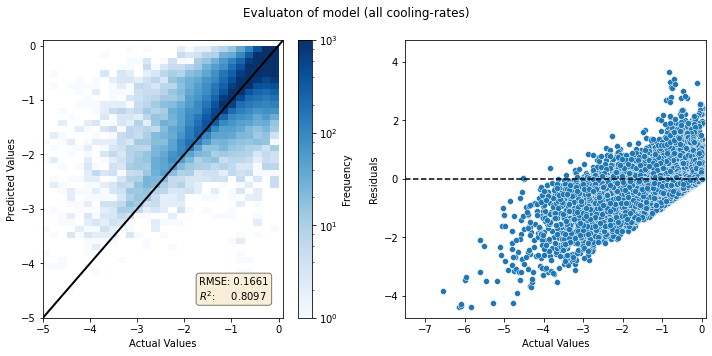

In [18]:
import matplotlib.colors as colors

threshold=-0.1
f1 = f1_score((y_val >= threshold), (y_pred >= threshold), average='macro')

residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.suptitle('Evaluaton of model (all cooling-rates)')
# Scatter plot with hist2d
hist = ax[0].hist2d(y_val, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/home/freimax/msc_thesis/figures/random_forest/IFS/tmeltsi/grid_search_model_cutoff_f1_{f1:.3f}.png',dpi=150)

In [19]:
feature_list = ['CC', 'T', 'OMEGA', 'SIWC', 'RH_ifs']

# Get numerical feature importances
importances = list(best_model_f1.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

Text(0.5, 1.0, 'Variable Importances')

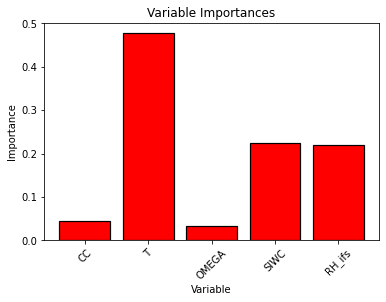

In [20]:
# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation=45)# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

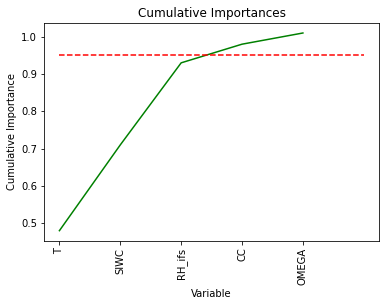

In [21]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

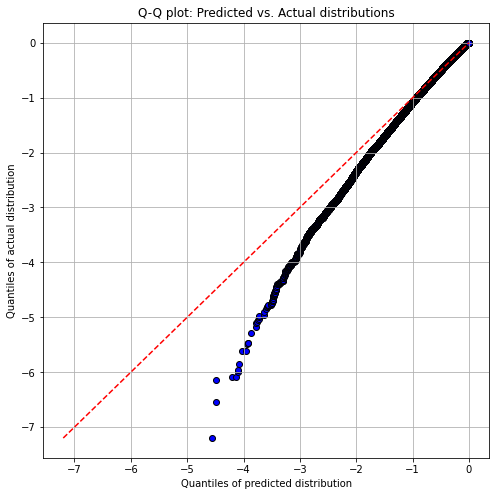

In [22]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


y_pred = best_model_f1.predict(X_val)

# Calculate the percentiles
y_pred_sorted = np.sort(y_pred)
y_val_sorted = np.sort(y_val)

# Generate percentiles
percentiles = np.linspace(0, 100, len(y_pred))

# Calculate the Q-Q pairs
q_pred = np.percentile(y_pred_sorted, percentiles)
q_val = np.percentile(y_val_sorted, percentiles)

# Generate the plot
plt.figure(figsize=(8,8))
plt.scatter(q_pred, q_val, edgecolor='k', color='blue')
plt.plot([np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 
         [np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 'r--')

plt.xlabel('Quantiles of predicted distribution')
plt.ylabel('Quantiles of actual distribution')
plt.title('Q-Q plot: Predicted vs. Actual distributions')
plt.grid(True)
plt.show()


---

(array([6.00000e+00, 1.50000e+01, 7.10000e+01, 2.11000e+02, 5.49000e+02,
        1.61100e+03, 4.18700e+03, 1.13970e+04, 3.10880e+04, 3.41854e+05]),
 array([-4.55913014e+00, -4.10321537e+00, -3.64730060e+00, -3.19138583e+00,
        -2.73547106e+00, -2.27955629e+00, -1.82364152e+00, -1.36772675e+00,
        -9.11811980e-01, -4.55897210e-01,  1.75591428e-05]),
 <BarContainer object of 10 artists>)

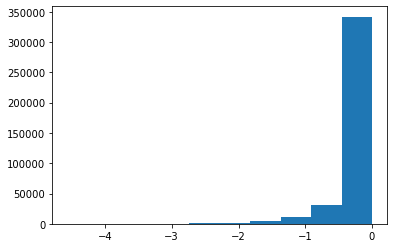

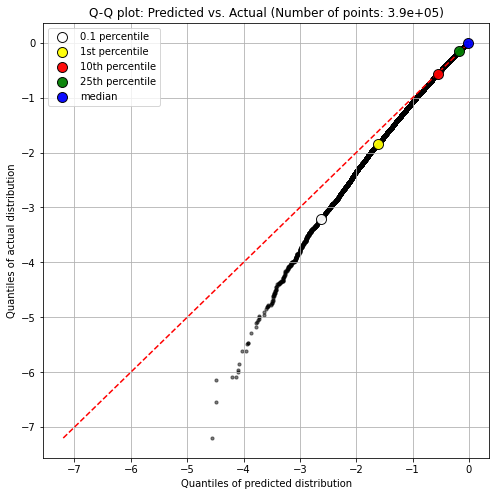

In [45]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


y_pred = best_model_f1.predict(X_val)

# Calculate the percentiles
y_pred_sorted = np.sort(y_pred)
y_val_sorted = np.sort(y_val)

# Generate percentiles
nr_points = len(y_pred)
percentiles = np.linspace(0, 100, nr_points ) 

# Calculate the Q-Q pairs
q_pred = np.percentile(y_pred_sorted, percentiles)
q_val = np.percentile(y_val_sorted, percentiles)
# Generate the plot
plt.figure(figsize=(8,8))
plt.scatter(q_pred, q_val, color='k', s=10, alpha=0.5)


# Mark median and other percentiles
p01_pred = np.percentile(q_pred, 0.1)
p01_val = np.percentile(q_val, 0.1)
plt.scatter(p01_pred, p01_val, color='white', edgecolor='k', label='0.1 percentile', s=100, zorder=5, alpha=0.95)

p1_pred = np.percentile(q_pred, 1)
p1_val = np.percentile(q_val, 1)
plt.scatter(p1_pred, p1_val, color='yellow', edgecolor='k', label='1st percentile', s=100, zorder=5, alpha=0.95)

p10_pred = np.percentile(q_pred, 10)
p10_val = np.percentile(q_val, 10)
plt.scatter(p10_pred, p10_val, color='red', edgecolor='k', label='10th percentile', s=100, zorder=5, alpha=0.95)

p25_pred = np.percentile(q_pred, 25)
p25_val = np.percentile(q_val, 25)
plt.scatter(p25_pred, p25_val, color='green', edgecolor='k', label='25th percentile', s=100, zorder=5, alpha=0.95)

median_pred = np.median(q_pred)
median_val = np.median(q_val)
plt.scatter(median_pred, median_val, color='blue', edgecolor='k', label='median', s=100, zorder=5, alpha=0.95)



# Diagonal line
plt.plot([np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 
         [np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 'r--')

plt.xlabel('Quantiles of predicted distribution')
plt.ylabel('Quantiles of actual distribution')
plt.title(f'Q-Q plot: Predicted vs. Actual (Number of points: {nr_points:2.1e})')
plt.grid(True)
plt.legend() 
plt.show()


---
---
#### From here are models that i tried to run, but that were not prmising
#### Following methods were tried:
- Scale target variable (with log)
- Regression + Classification model (Here i only tried to use a threshold to cut-off the data that is used for regression, this cut would be learned by regression)

---
## Scale dependent variables (logscale) 

In [17]:
transformer_y = FunctionTransformer(np.log1p, validate=True)

---
#### Why are there heating values?

In [18]:
pos_val_frac = (y_train.values>0).sum() / (y_train.values<=0).sum()
print(f'The fraction of positve cooling (HEATING) os: {pos_val_frac:.4f} (of 1).')
print(f'The maximal heating value is: {y_train.values.max():.5f}')

The fraction of positve cooling (HEATING) os: 0.2588 (of 1).
The maximal heating value is: 0.00021


In [19]:
y_train_trans = transformer_y.fit_transform(-(y_train.values).reshape(-1, 1)).ravel()
y_val_trans= transformer_y.transform(-(y_val.values).reshape(-1, 1)).ravel()

In [40]:
# Define a function to apply your custom transformation to y
def custom_transform(y):
    return np.log(-y + 1e-3)

def custom_inverse_transform(y_transformed):
    return -(np.exp(y_transformed) - 1e-3)

(-7.75, 3.25)

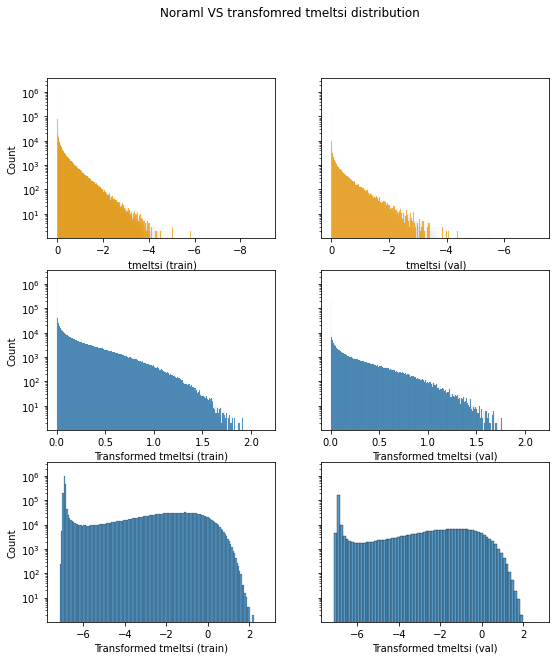

In [56]:


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9, 10), sharey=True)
plt.suptitle('Noraml VS transfomred tmeltsi distribution')

sns.histplot(y_train, log_scale=(False,True), ax=ax[0,0], color='orange')
ax[0,0].set_xlabel(' tmeltsi (train)')
ax[0,0].invert_xaxis()
#ax[1].set_xlim(-0.1,2.25)

sns.histplot(y_val, log_scale=(False,True), ax=ax[0,1],  color='orange')
ax[0,1].set_xlabel(' tmeltsi (val)')
ax[0,1].invert_xaxis()
#ax[3].set_xlim(-0.1,2.25)

sns.histplot(y_train_trans, log_scale=(False,True), ax=ax[1,0])
ax[1,0].set_xlabel('Transformed tmeltsi (train)')
ax[1,0].set_xlim(-0.1,2.25)

sns.histplot(y_val_trans, log_scale=(False,True), ax=ax[1,1])
ax[1,1].set_xlabel('Transformed tmeltsi (val)')
ax[1,1].set_xlim(-0.1,2.25)


# sns.histplot(y_train_trans, log_scale=(False,True))
sns.histplot(custom_transform(df_tmeltsi_train.tmeltsi),  log_scale=(False,True), ax=ax[2,0])
ax[2,0].set_xlabel('Transformed tmeltsi (train)')
ax[2,0].set_xlim(-7.75,3.25)

# sns.histplot(y_val_trans, log_scale=(False,True), )
sns.histplot(custom_transform(df_tmeltsi_val.tmeltsi),  log_scale=(False,True), ax=ax[2,1] )
ax[2,1].set_xlabel('Transformed tmeltsi (val)')
ax[2,1].set_xlim(-7.75,3.25)



In [65]:
transformer_y = FunctionTransformer(np.log1p, validate=True)
y_train_trans = transformer_y.fit_transform(-(y_train.values).reshape(-1, 1)).ravel()

y_train1 = transformer_y.inverse_transform(y_train_trans.reshape(-1, 1))

assert np.allclose(y_train_trans.flatten(), y_train1.flatten())

In [67]:
def grid_search_with_validation_scale_y(X_train, y_train, 
                                        X_val  , y_val  , 
                                        param_grid, 
                                        save_name,
                                        transfomr_type=1,
                                        ):


    # Apply the custom transformation to y_train and y_val
    if transfomr_type==1:
        print('Applying Custom tranform')
        y_train_transformed = custom_transform(y_train)
    elif transfomr_type==2:
        print('Applying FunctionTransform (np.logp1)')
        transformer_y = FunctionTransformer(np.log1p, validate=True)
        y_train_transformed = transformer_y.fit_transform(-(y_train.values).reshape(-1, 1)).ravel()


    best_mse = np.inf
    best_params = None
    best_model = None

    total_iter = 1
    for key in param_grid.keys():
        total_iter *= len(param_grid[key])
    current_i = 0
    print('\nStart Grid-Search:')
    # Loop over the parameter grid
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for max_features in param_grid['max_features']:
                for min_samples_split in param_grid['min_samples_split']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        for criterion in param_grid['criterion']:
                            current_i +=1
                            
                            # Create and train a Random Forest model
                            rf = RandomForestRegressor(n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        max_features=max_features,
                                                        min_samples_split=min_samples_split,
                                                        min_samples_leaf=min_samples_leaf,
                                                        criterion=criterion,
                                                        n_jobs=58)
                            

                            rf.fit(X_train, y_train_transformed)
                            # Predict the validation set results and compute the mean squared error
                            y_pred_transformed = rf.predict(X_val)


                            if transfomr_type==1:
                                # Apply the custom transformation to y_train and y_val
                                y_pred = custom_inverse_transform(y_pred_transformed)  # transform predictions back
                            elif transfomr_type==2:
                                y_pred = transformer_y.inverse_transform(y_pred_transformed.reshape(-1, 1))
                            
                            mse = mean_squared_error(y_val, y_pred)
                            
                            # If this is the best model so far, save its parameters and score
                            if mse < best_mse:
                                best_mse = mse
                                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features, 'min_samples_split': min_samples_split}
                                best_model = rf

                                print(f'Model {current_i:3} of {total_iter:3} | n_estimators ={n_estimators:4} | max_depth = {max_depth} | max_features ={max_features:3} | min_samples_split ={min_samples_split:3}| min_samples_leaf ={min_samples_leaf:2} | criterion = {criterion} | RMSE: {np.sqrt(mse):.5f}  (NEW BEST)')
    
    print(f'\nBest parameters: {best_params}')
    print(f'Best MSE: {best_mse}  -->  Best RMSE: {np.sqrt(best_mse)}')

    dump(best_model, f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/tmeltsi/{save_name}.joblib')
    return best_model, best_params



In [68]:
param_grid2 = {
    'n_estimators': [750],
    'max_depth': [50],
    'max_features': [2,3],
    'min_samples_split': [25, 30],
    'min_samples_leaf':[7,9],
    'criterion': ['squared_error']
}

# Call the function
model_trans_type1, params_trans_type1 = grid_search_with_validation_scale_y(X_train=X_train,
                                                                            y_train=y_train, 
                                                                            X_val=X_val, 
                                                                            y_val=y_val, 
                                                                            param_grid=param_grid2,
                                                                            save_name='girdsearch_Yneglog_tmeltsi',
                                                                            transfomr_type=1
                                                                            )


print('\n==================================================================================================\nNow using FunctionTransform\n==================================================================================================\n')

# Call the function
model_trans_type2, params_trans_type2 = grid_search_with_validation_scale_y(X_train=X_train,
                                                                            y_train=y_train, 
                                                                            X_val=X_val, 
                                                                            y_val=y_val, 
                                                                            param_grid=param_grid2,
                                                                            save_name='girdsearch_Yneglog_tmeltsi',
                                                                            transfomr_type=2
                                                                            )

Applying Custom tranform

Start Grid-Search:
Model   1 of   8 | n_estimators = 750 | max_depth = 50 | max_features =  2 | min_samples_split = 25| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.18814  (NEW BEST)
Model   5 of   8 | n_estimators = 750 | max_depth = 50 | max_features =  3 | min_samples_split = 25| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.18653  (NEW BEST)
Model   6 of   8 | n_estimators = 750 | max_depth = 50 | max_features =  3 | min_samples_split = 25| min_samples_leaf = 9 | criterion = squared_error | RMSE: 0.18644  (NEW BEST)
Model   8 of   8 | n_estimators = 750 | max_depth = 50 | max_features =  3 | min_samples_split = 30| min_samples_leaf = 9 | criterion = squared_error | RMSE: 0.18644  (NEW BEST)

Best parameters: {'n_estimators': 750, 'max_depth': 50, 'max_features': 3, 'min_samples_split': 30}
Best MSE: 0.0347585613143365  -->  Best RMSE: 0.18643648064243357

Now using FunctionTransform

Applying FunctionTransform (np.logp1)

Start G

In [70]:
# Predict using your validation set
y_pred_transformed = model_trans_type1.predict(X_val)
y_pred = custom_inverse_transform(y_pred_transformed)

Root Mean Squared Error (RMSE): 0.18643648064243357
R-squared: 0.7601466520381993


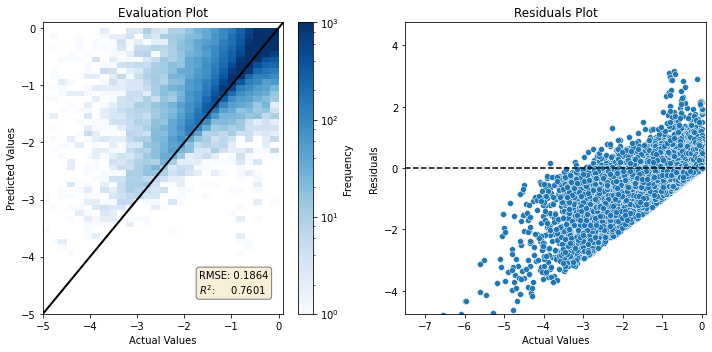

In [71]:
import matplotlib.colors as colors

residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals Plot')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/net/helium/atmosdyn/freimax/figures/random_forest/IFS/tmeltsi/single_forest_noscale/tmeltsi_log_transform_rmse_{rmse:.3f}.png',dpi=150)

---
---
## Try Regression model after classification model

In [73]:
def apply_cooling_thr(X,y, thr):
    X_cutoff = X[y <= thr]
    y_cutoff = y[y <= thr]
    assert X_cutoff.shape[0] == y_cutoff.shape[0]
    print(f'New shape:\t{X_cutoff.shape }\t\tOld shape:\t{X.shape}')
    return X_cutoff, y_cutoff

In [74]:
param_grid2 = {
    'n_estimators': [1000],
    'max_depth': [30],
    'max_features': [2],
    'min_samples_split': [30, 40],
    'min_samples_leaf':[7],
    'criterion': ['squared_error']
}


cutoff_models = []
cutoff_params = []
thr_list = [-0.1, -0.01, -0.001, -0.0001]
for thr in thr_list:
    print(f'\n\nCooling cutoff: {thr}')
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    # Call the function
    cutoff_model, cutoff_param = grid_search_with_validation_set(X_train=X_train_cutoff,
                                                                y_train=y_train_cutoff, 
                                                                X_val=X_val_cutoff, 
                                                                y_val=y_val_cutoff, 
                                                                param_grid=param_grid2,
                                                                save_name=f'cutoff_{thr}_tmeltsi'
                                                                )
    cutoff_models.append(cutoff_model)
    cutoff_params.append(cutoff_param)



Cooling cutoff: -0.1
New shape:	(1204720, 5)		Old shape:	(3993401, 5)
New shape:	(117142, 5)		Old shape:	(390989, 5)

Start Grid-Search:
Model   1 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 30| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.26914  (NEW BEST)

Best parameters: {'n_estimators': 1000, 'max_depth': 30, 'max_features': 2, 'min_samples_split': 30}
Best MSE: 0.07243571234267424  -->  Best RMSE: 0.2691388346981428


Cooling cutoff: -0.01
New shape:	(1887901, 5)		Old shape:	(3993401, 5)
New shape:	(181413, 5)		Old shape:	(390989, 5)

Start Grid-Search:
Model   1 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 30| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.23588  (NEW BEST)
Model   2 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 40| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.23583  (NEW BEST)

Best parameters: {

In [75]:
# Predict using your validation set
y_pred = big_model.predict(X_val_cutoff)

assert y_pred.shape[0] == y_val_cutoff.shape[0]

Root Mean Squared Error (RMSE): 0.21913111362715043
R-squared: 0.7777665369341814


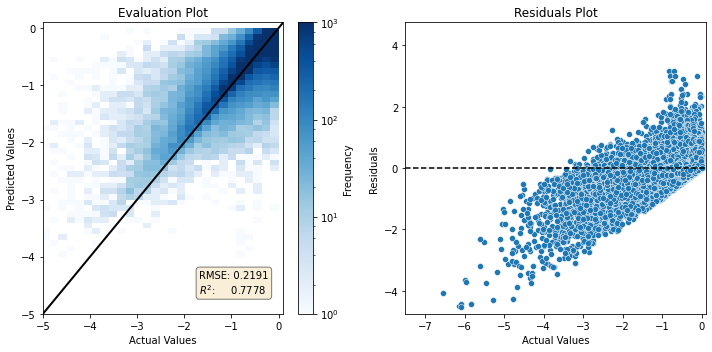

In [76]:
import matplotlib.colors as colors

residuals = y_val_cutoff - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val_cutoff, y_pred))
r2 = r2_score(y_val_cutoff, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val_cutoff, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val_cutoff, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals Plot')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/net/helium/atmosdyn/freimax/figures/random_forest/IFS/tmeltsi/single_forest_noscale/tmeltsi_cutoff_model_rmse_{rmse:.3f}.png',dpi=150)

In [77]:
thr_list = [-0.1, -0.01, -0.001, -0.0001]

rmse_co_list = []
r2_co_list = []

for i, thr in enumerate(thr_list):
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    
    y_pred_CO = cutoff_models[i].predict(X_val_cutoff)

    # Calculate metrics
    rmse_co_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_CO)))
    r2_co_list.append(r2_score(y_val_cutoff, y_pred_CO))




New shape:	(1204720, 5)		Old shape:	(3993401, 5)
New shape:	(117142, 5)		Old shape:	(390989, 5)
New shape:	(1887901, 5)		Old shape:	(3993401, 5)
New shape:	(181413, 5)		Old shape:	(390989, 5)
New shape:	(2160321, 5)		Old shape:	(3993401, 5)
New shape:	(206264, 5)		Old shape:	(390989, 5)
New shape:	(2315031, 5)		Old shape:	(3993401, 5)
New shape:	(220149, 5)		Old shape:	(390989, 5)


In [78]:
y_pred_full = big_model.predict(X_val)
threshold_list = np.arange(-0.0001,-1, -0.001)#[-0.1, -0.01, -0.005, -0.001, -0.0001]

rmse_list =[]
r2_list = []
for i,thr in enumerate(threshold_list):
    y_val_cutoff = y_val[y_val<=thr] 
    y_pred_full_cutoff = y_pred_full[y_val<=thr]

    rmse_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_full_cutoff)))
    r2_list.append(r2_score(y_val_cutoff, y_pred_full_cutoff))
    
    if (i+1) % 100 == 0:
        print(f'Done with step {i} of {threshold_list.shape[0]}')

Done with step 99 of 1000
Done with step 199 of 1000
Done with step 299 of 1000
Done with step 399 of 1000
Done with step 499 of 1000
Done with step 599 of 1000
Done with step 699 of 1000
Done with step 799 of 1000
Done with step 899 of 1000
Done with step 999 of 1000


/tmp/ipykernel_55607/2939554271.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim(-0.01, 0.15)


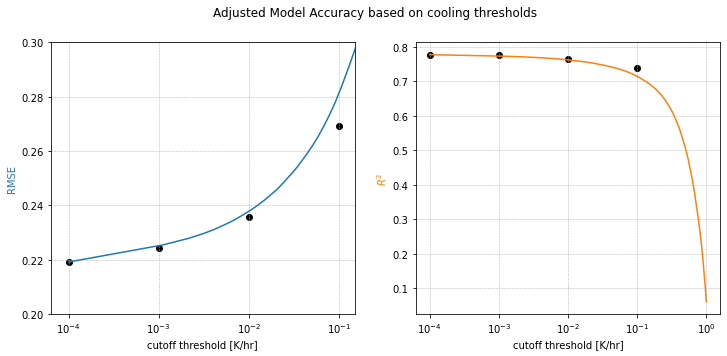

In [79]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Adjusted Model Accuracy based on cooling thresholds', fontsize=12)

ax[0].plot(-threshold_list, rmse_list, c='#1f77b4')
#ax[0].invert_xaxis()
ax[0].set_xlabel('cutoff threshold [K/hr]')
ax[0].set_ylabel('RMSE', c='#1f77b4', fontsize=10)
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(0.2, 0.3)
ax[0].set_xlim(-0.01, 0.15)

ax[1].plot(-threshold_list, r2_list, c='#ff7f0e')
#ax[1].invert_xaxis()
ax[1].set_ylabel(r'$R^2$', c='#ff7f0e', fontsize=10)
ax[1].set_xlabel('cutoff threshold [K/hr]')
ax[1].set_xscale('log')

ax[0].scatter([-x for x in thr_list], rmse_co_list, c='k')
ax[1].scatter([-x for x in thr_list], r2_co_list, c='k')

# Adding grid lines
for axes in ax:
    if axes.get_xscale() == 'log':
        axes.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        axes.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        axes.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=150))
    else:
        axes.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

plt.show()


In [80]:
y_val_cutoff = y_val[y_val<=-0.1] 
y_pred_full_cutoff = y_pred_full[y_val<=-0.1]
y_pred_CO = cutoff_models[-1].predict(X_val_cutoff)


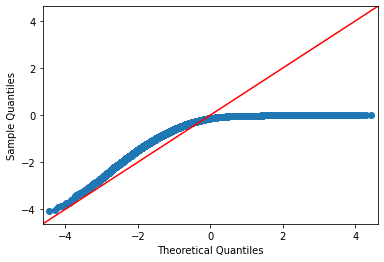

In [81]:
import statsmodels.api as sm
import pylab as py
sm.qqplot(y_pred_CO, line ='45')
py.show()